In [9]:
from typing import Sequence
import coba
from coba.random      import CobaRandom
from coba.simulations import LambdaSimulation, ConstrainedSimulation, Context, Action
from coba.learners    import RandomLearner, VowpalLearner, ChanceConstrainedOptimizer, EpsilonBanditLearner
from coba.benchmarks  import Benchmark

In [5]:
n_interactions = 1000
r = CobaRandom()

In [6]:
def context(index: int) -> Context:
    return tuple(r.randoms(5))

def actions(index: int, context: Context) -> Sequence[Action]:
    return [1, 2]
    #actions = [ r.randoms(5) for _ in range(3) ]
    #return [ tuple(a/sum(action) for a in action) for action in actions ]

def rewards(index: int, context: Context, action: Action) -> float:
    if action == 1:
        return 0.5
    else:
        return 0.9

def feedback(index: int, context: Context, action: Action) -> Sequence[float]:
    if action == 1:
        return tuple((0.5, -1))
    return tuple((0.9, 0.8))

In [13]:
sim = [ConstrainedSimulation(n_interactions, context, actions, feedback)]

result = Benchmark(sim).evaluate([ChanceConstrainedOptimizer(constraint=0.1, len_feedback=1, learning_rate=0.3, learner=VowpalLearner, vw_kwargs={"bag":5, "seed":10}), 
                         ChanceConstrainedOptimizer(constraint=0.1, len_feedback=1, learning_rate=0.3, learner=RandomLearner),
                        ChanceConstrainedOptimizer(constraint=0.1, len_feedback=1, learning_rate=0.3, learner=EpsilonBanditLearner, vw_kwargs={"epsilon":0.1})])

2021-08-05 13:27:24 Processing chunk...
2021-08-05 13:27:24   * Creating source 0 from "ConstrainedSimulation"... (0.0 seconds) (completed)
2021-08-05 13:27:24   * Creating simulation 0 from source 0... (0.0 seconds) (completed)
2021-08-05 13:27:25   * Evaluating learner 0 on Simulation 0... (0.43 seconds) (completed)
2021-08-05 13:27:25   * Evaluating learner 1 on Simulation 0... (0.13 seconds) (completed)
2021-08-05 13:27:25   * Evaluating learner 2 on Simulation 0... (0.15 seconds) (completed)


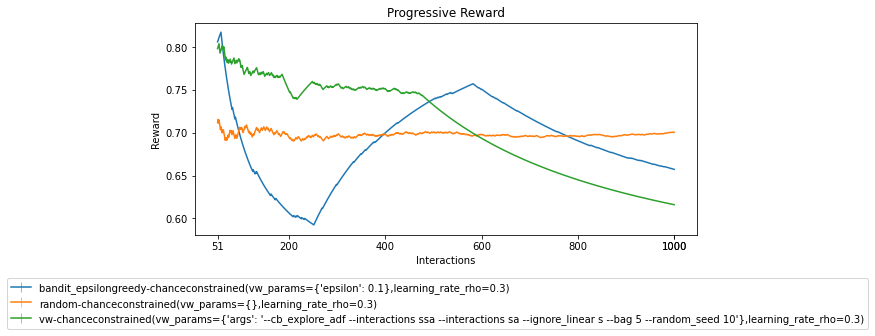

In [14]:
result.plot_learners()

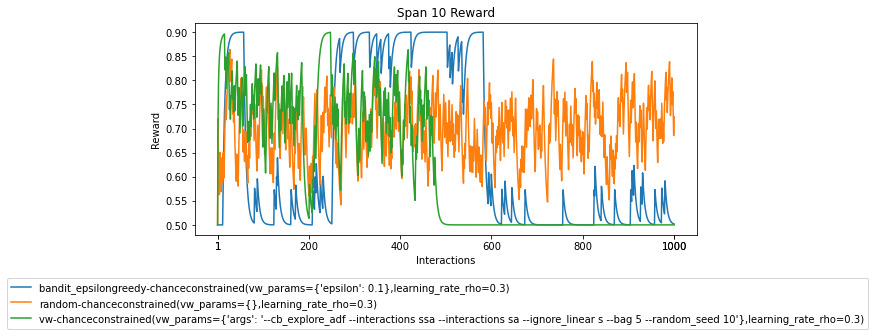

In [16]:
result.plot_learners(start=0.0, end=1.0, span=10 , err_every=0)

In [17]:
result_no_random = Benchmark(sim).evaluate([ChanceConstrainedOptimizer(constraint=0.1, len_feedback=1, learning_rate=0.3, learner=VowpalLearner, vw_kwargs={"bag":5, "seed":10}), 
                        ChanceConstrainedOptimizer(constraint=0.1, len_feedback=1, learning_rate=0.3, learner=EpsilonBanditLearner, vw_kwargs={"epsilon":0.1})])

2021-08-05 13:30:12 Processing chunk...
2021-08-05 13:30:12   * Creating source 0 from "ConstrainedSimulation"... (0.0 seconds) (completed)
2021-08-05 13:30:12   * Creating simulation 0 from source 0... (0.0 seconds) (completed)
2021-08-05 13:30:12   * Evaluating learner 0 on Simulation 0... (0.48 seconds) (completed)
2021-08-05 13:30:13   * Evaluating learner 1 on Simulation 0... (0.16 seconds) (completed)


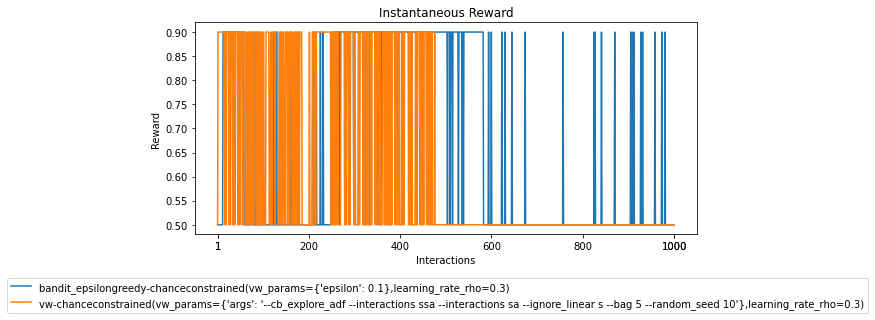

In [18]:
result_no_random.plot_learners(start=0.0, end=1.0, span=1 , err_every=0)